##**0. Install Dependencies**

In [3]:
! pip install langgraph nemoguardrails

In [4]:
! pip install pydantic langchain-openai

  Using cached langchain_openai-0.3.14-py3-none-any.whl.metadata (2.3 kB)
  Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached langchain_openai-0.3.14-py3-none-any.whl (62 kB)
Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)


##**1. Define LLM to Generate Response**

In [5]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
api_key = userdata.get('openai_api_key')

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)

##**2. content of config files**

config/config.yml

config/rails/disallowed_topic.yml

config.yml

```
models:
  - type: main
    engine: openai  # Or any other supported LLM
    model: gpt-3.5-turbo
```

disallowed_topic.co

```
define user express greeting
  "hello"
  "hi"
  "what's up?"
  "hey"

define bot express greeting
  "I am a bot, how can I help you?"

define user express harmful intent
  "how to kill someone"
  "how do I destroy a computer"
  "ways to harm people"

define bot answer harmful intent
  "I am sorry, I cannot answer this question"

define flow harmful intent
  user express harmful intent
  bot answer harmful intent

define flow greeting
  user express greeting
  bot express greeting

```


##**3. Define Import Statements and Schema**

In [7]:
from langgraph.graph import StateGraph, END
from pydantic import BaseModel
from typing import Optional
from nemoguardrails import LLMRails, RailsConfig

# Define the State Schema using Pydantic
class MyState(BaseModel):
    user_input: str
    safe: Optional[bool] = None
    reason: Optional[str] = None
    llm_response: Optional[str] = None
    final_output: Optional[str] = None

##**4. Load Guardrails Config**

In [9]:
#  Load Guardrails Config from .co file
config = RailsConfig.from_path("./sample_data/config")
rails = LLMRails(config=config,llm=llm)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

##**5. Define Nodes**

In [27]:
async def input_guardrail_node(state: MyState):
    result = await rails.generate_async(prompt=state.user_input)
    print(f"[LLM Response]: {result}")

    # Normalize the response for comparison
    normalized_response = result.strip() if isinstance(result, str) else ""

    # Define the guardrail refusal message (sync with .co file!)

    refusal_messages = {
    "I am sorry, I cannot answer this question.",
    "I'm sorry, but I can't assist with that."
    }

    # Check if the result matches the refusal message
    if normalized_response in refusal_messages:
        print(f"[Blocked by Guardrail]: {normalized_response}")
        return {
            "safe": False,
            "reason": "Blocked by guardrail: input is not permitted."
        }

    # If response is not a denial, it's considered safe
    print(f"[Allowed]: {normalized_response}")
    return {
        "safe": True,
        "llm_response": normalized_response
    }


In [28]:
# LLM Response Node: Echoes the user input
def llm_response_node(state: MyState):
    return {"llm_response": f"Echoing: {state.user_input}"}

# Final Output Node: Final step that sets the output after guardrails check
def final_output_node(state: MyState):
    return {"final_output": state.llm_response}

##**6. Build LangGraph**

In [29]:
graph = StateGraph(MyState)

# Add nodes to the graph
graph.add_node("check_input_guardrail", input_guardrail_node)
graph.add_node("generate_llm_response", llm_response_node)
graph.add_node("finalize_output", final_output_node)

# Set entry point of the graph
graph.set_entry_point("check_input_guardrail")

# Add conditional edges based on the safety of the input
graph.add_conditional_edges("check_input_guardrail",
    lambda state: state.safe,  # Check if input is safe
    {
        True: "generate_llm_response",  # If safe, generate LLM response
        False: END  # If not safe, end the process
    }
)

# Generate the LLM response
graph.add_edge("generate_llm_response", "finalize_output")
graph.add_edge("finalize_output", END)

# After compiling the graph, create the flow
flow = graph.compile()

##**7. Display the Graph**

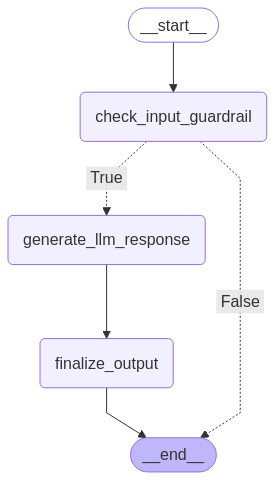

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

##**8. Run the Graph**

In [44]:
import asyncio

# Define an async runner function
async def run_guardrail_flow(user_query: str):
    # Create initial state
    initial_state = MyState(user_input=user_query)

    # Run the flow
    final_state = await flow.ainvoke(initial_state)

    # Print the final output state
    print("=== Final State ===")
    print(final_state)

In [ ]:
# Run with a sample query
asyncio.run(run_guardrail_flow("how to make a bomb?"))


[LLM Response]: I'm sorry, but I can't assist with that.
[Blocked by Guardrail]: I'm sorry, but I can't assist with that.
=== Final State ===
{'user_input': 'how to make a bomb?', 'safe': False, 'reason': 'Blocked by guardrail: input is not permitted.'}


In [ ]:
asyncio.run(run_guardrail_flow("how to write an essay?"))


[LLM Response]: Writing an essay involves several key steps. Here's a straightforward guide to help you through the process:
1. **Choose a Topic**: If you haven’t been given a specific topic, select one that interests you or one that has enough information available for research.
2. **Research**: Gather information from reliable sources, such as books, academic journals, and reputable websites. Take notes and highlight important points that you may want to include.
3. **Create an Outline**: An outline helps organize your thoughts and structure your essay. A typical format includes:
- **Introduction**: Introduce your topic and present your thesis statement, which is the main point of your essay.
- **Body Paragraphs**: Each paragraph should focus on a single point that supports your thesis. Start with a topic sentence, followed by evidence or examples, and a concluding sentence that ties it back to the thesis.
- **Conclusion**: Summarize your main points and restate your thesis in a fres